In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from glob import glob
import scipy.io as sio
from scipy import ndimage as nd
from scipy import misc
from scipy.io import loadmat
from tqdm import tqdm
import multiprocessing as mp
import pickle
import math
import matplotlib.pyplot as plt
import PIL.Image as pim
import PIL.ImageOps as pop
import seaborn as sns
%matplotlib inline

In [3]:
fpX = np.float32
from src.numpy_utility import mosaic_vis, iterate_minibatches
from src.file_utility import save_stuff #pip install nibabel     shiyong yixue 3D tuxiang shuju

In [4]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [5]:
root_dir = os.getcwd() + '/'
output_dir = root_dir + "output/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

print ("Current dir: %s" % root_dir)
print ("Time Stamp: %s" % timestamp)

Current dir: /md_disk7/guoyuan/Mufan/code/nsd-master/
Time Stamp: Sep-14-2022_1456


In [6]:
def applyCropToImg(img, box): #image cutting
    '''
    applyCropToImg(img, cropBox)
    img ~ any h x w x n image
    cropBox ~ (top, bottom, left, right) in fractions of image size
    '''
    if box[0]+box[1] >= 1:
        raise ValueError('top and bottom crop must sum to less than 1')
    if box[2]+box[3] >= 1:
        raise ValueError('left and right crop must sum to less than 1')
    shape = img.shape
    topCrop = np.round(shape[0]*box[0]).astype(int)
    bottomCrop = np.round(shape[0]*box[1]).astype(int)
    leftCrop = np.round(shape[1]*box[2]).astype(int)
    rightCrop = np.round(shape[1]*box[3]).astype(int)
    croppedImage = img[topCrop:(shape[0]-bottomCrop),leftCrop:(shape[1]-rightCrop)]
    return croppedImage

def maskToIndices(img):
    return img[:,:,0]+img[:,:,1]*256+img[:,:,2]*(256**2)
def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return imgSegIds

def maskToUniqueIndices(img):
    imgSegIds = list(np.unique(maskToIndices(img)))
    if 0 in imgSegIds:
        imgSegIds.remove(0)
    return np.unique(imgSegIds)
def getCategoryIDs(annotations, imgSegIds):
    segToCatId = defaultdict(list)
    for ann in annotations:
        for seg in ann['segments_info']:
            segToCatId[seg['id']] = seg['category_id']
    return [segToCatId[s] for s in imgSegIds if s in segToCatId]

def getCategoryNames(catIdToCat, catIds):
    # getCategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['name'] for c in catIds])
def getSupercategoryNames(catIdToCat, catIds):
    # getSupercategoryNames(catToCat, catIds)
    return np.unique([catIdToCat[c][0]['supercategory'] for c in catIds])

def supercategoryMap(croppedImg, annotations, embbeding):
    # supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    segmentMap = maskToIndices(croppedImg).flatten()
    superMap = np.full(fill_value=-1, shape=segmentMap.shape, dtype=np.int)
    imgSegIds = maskToUniqueIndices(croppedImg)
    catIds = getCategoryIDs(annotations, imgSegIds)
    for c,s in zip(catIds, imgSegIds):
        supercat = getSupercategoryNames(catIdToCat, [c])[0]
        superMap[segmentMap==s] = embbeding[supercat]            
    return superMap.reshape(croppedImg.shape[:2])

d## Load a dataset

In [7]:
nsd_root   = "/md_disk7/guoyuan/Mufan/nsd/"
stim_root  = nsd_root + "nsddata_stimuli/stimuli/nsd/"
synth_root = nsd_root + "nsddata_stimuli/stimuli/nsdsynthetic/"
beta_root  = nsd_root + "nsddata_betas/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
synth_design_file = nsd_root + "nsddata/experiments/nsdsynthetic/nsdsynthetic_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"
synth_file      = synth_root + "nsdsynthetic_stimuli.hdf5"
print (nsd_root)
print (stim_root)
print (synth_root)
print (beta_root)
print (exp_design_file)
print (synth_design_file)
print (stim_file)
print (synth_file)

/md_disk7/guoyuan/Mufan/nsd/
/md_disk7/guoyuan/Mufan/nsd/nsddata_stimuli/stimuli/nsd/
/md_disk7/guoyuan/Mufan/nsd/nsddata_stimuli/stimuli/nsdsynthetic/
/md_disk7/guoyuan/Mufan/nsd/nsddata_betas/ppdata/
/md_disk7/guoyuan/Mufan/nsd/nsddata/experiments/nsd/nsd_expdesign.mat
/md_disk7/guoyuan/Mufan/nsd/nsddata/experiments/nsdsynthetic/nsdsynthetic_expdesign.mat
/md_disk7/guoyuan/Mufan/nsd/nsddata_stimuli/stimuli/nsd/nsd_stimuli.hdf5
/md_disk7/guoyuan/Mufan/nsd/nsddata_stimuli/stimuli/nsdsynthetic/nsdsynthetic_stimuli.hdf5


In [8]:
exp_design = loadmat(exp_design_file)

In [9]:
print (exp_design.keys())

dict_keys(['__header__', '__version__', '__globals__', 'basiccnt', 'masterordering', 'sharedix', 'stimpattern', 'subjectim'])


In [10]:
basic_cnt    = exp_design['basiccnt']
shared_idx   = exp_design['sharedix']
subject_idx  = exp_design['subjectim']
trial_order  = exp_design['masterordering']
stim_pattern = exp_design['stimpattern']

In [11]:
print (np.min(trial_order), np.max(trial_order))

1 10000


In [13]:
print ("Loading block...")
image_data_set = h5py.File(stim_file,mode='r')
print (image_data_set.keys())
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()
print (image_data.shape)

(73000, 425, 425, 3)
Loading block...
<KeysViewHDF5 ['imgBrick']>
(73000, 425, 425, 3)


In [15]:
print (shared_idx.shape)
print (np.min(shared_idx), np.max(shared_idx))

(1, 1000)
2951 72949
(1, 1000)
2951 72949


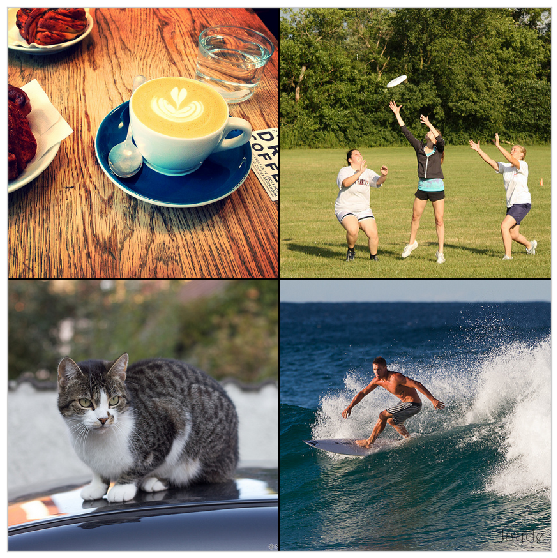

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(mosaic_vis(image_data[shared_idx[0,6:10]-1].astype(np.float32), pad=2), cmap='gray', interpolation='None')
plt.gca().get_xaxis().set_visible(False)
plt.gca().get_yaxis().set_visible(False)

---

# Subject-wise image block
## Native resolution

In [17]:
for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data[s_idx - 1].transpose(0,3,1,2)
    print (s_image_data.shape)
    save_stuff("%sS%d_stimuli_native"%(stim_root, k+1), {'stimuli': s_image_data})

(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file
(10000, 3, 425, 425)
saved stimuli in h5py file


## Downsampled resolution

In [18]:
def resize_image_tensor(x, newsize):
    tt = x.transpose((0,2,3,1))
    r  = np.ndarray(shape=x.shape[:1]+newsize+(x.shape[1],), dtype=tt.dtype) 
    for i,t in enumerate(tt):
        r[i] = np.asarray(pim.fromarray(t).resize(newsize, resample=pim.BILINEAR))
    return r.transpose((0,3,1,2))   

In [25]:
nx = 227
for k,s_idx in enumerate(subject_idx):
    s_image_data = image_data[s_idx - 1]
    # s_image_data = np.asarray(pim.fromarray(s_image_data.transpose(0,3,1,2)).resize((nx,nx),resample=pim.BILINEAR))
    s_image_data = resize_image_tensor(s_image_data.transpose(0,3,1,2), newsize=(nx,nx))  #flip or rotate in 90 degree steps

    print (s_image_data.shape)
    save_stuff("%sS%d_stimuli_%d"%(stim_root, k+1, nx), {'stimuli': s_image_data})

/tmp/ipykernel_15755/196710307.py:5: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  r[i] = np.asarray(pim.fromarray(t).resize(newsize, resample=pim.BILINEAR))


(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file
(10000, 3, 227, 227)
saved stimuli in h5py file


# NSD Synthetic images

In [20]:
exp_design = loadmat(synth_design_file)

FileNotFoundError: [Errno 2] No such file or directory: '/md_disk7/guoyuan/Mufan/nsd/nsddata/experiments/nsdsynthetic/nsdsynthetic_expdesign.mat'

In [121]:
print (exp_design.keys())

dict_keys(['__header__', '__version__', '__globals__', 'basiccnt', 'masterordering', 'sharedix', 'stimpattern', 'subjectim'])


In [122]:
trial_order  = exp_design['masterordering']
stim_pattern = exp_design['stimpattern']

In [123]:
print (trial_order.shape)
print (len(trial_order[0]))
print (np.min(trial_order), np.max(trial_order))

(1, 30000)
30000
1 10000


In [124]:
1360-714

646

In [125]:
print ("Loading block...")
image_data_set = h5py.File(synth_file, 'r')
print (image_data_set.keys())
image_data = np.copy(image_data_set['imgBrick'])
image_data_set.close()
print image_data.shape

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(image_data.shape)? (2747728156.py, line 6)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

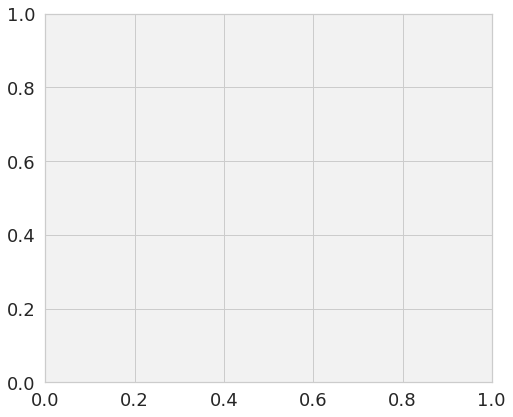

In [31]:
n_examples=10
plt.figure(figsize=(8,8*n_examples))
for k, n in enumerate(np.arange(0, len(image_data), len(image_data)/10)):
    plt.subplot(n_examples,1,k+1)
    plt.imshow(image_data[n])

# Crop and downsample to Alexnet/Gnet input resolution

In [26]:
def resize_image_tensor(x, newsize):
    tt = x.transpose((0,2,3,1))
    r  = np.ndarray(shape=x.shape[:1]+newsize+(x.shape[1],), dtype=tt.dtype) 
    for i,t in enumerate(tt):
        r[i] = np.asarray(pim.fromarray(t).resize(newsize, resample=pim.BILINEAR))
    return r.transpose((0,3,1,2))   

In [27]:
print (image_data.shape)

(73000, 425, 425, 3)


In [28]:
nx = 227
shared_image_downsampled = resize_image_tensor(image_data[:,:,323:323+714].transpose(0,3,1,2), newsize=(nx,nx))
print (shared_image_downsampled.shape)

/tmp/ipykernel_15755/196710307.py:5: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  r[i] = np.asarray(pim.fromarray(t).resize(newsize, resample=pim.BILINEAR))


(73000, 3, 227, 227)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

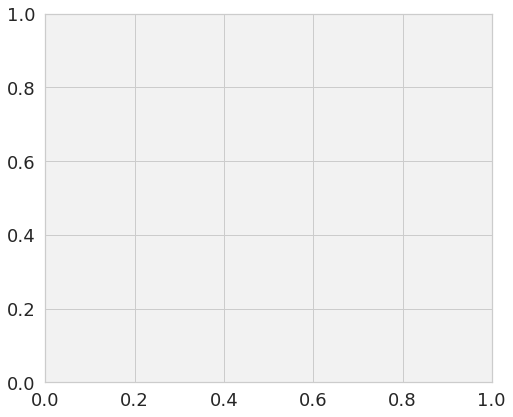

In [32]:
un_examples=10
plt.figure(figsize=(8,8*n_examples))
for k, n in enumerate(np.arange(0, len(image_data), len(image_data)/10)):
    plt.subplot(n_examples,1,k+1)
    plt.imshow(shared_image_downsampled[n].transpose((1,2,0)))

## Resize the subjectwise images, concatenate and save

In [33]:
subjects = np.arange(1,9)
nx = 227
for s in subjects:
    print ("Loading block...")
    image_data_set = h5py.File(synth_root + 'nsdsynthetic_colorstimuli_subj%02d.hdf5'%s, 'r')
    print (image_data_set.keys())
    image_data = np.copy(image_data_set['imgBrick'])
    image_data_set.close()
    
    s_image_data = resize_image_tensor(image_data[:,:,323:323+714].transpose(0,3,1,2), newsize=(nx,nx))
    print (image_data.shape, '>', s_image_data.shape, '+', shared_image_downsampled.shape)
    s_image_data = np.concatenate([shared_image_downsampled, s_image_data], axis=0)
    print ('=', s_image_data.shape)
    
    save_stuff("%sS%d_synth_stimuli_%d"%(stim_root, s, nx), {'stimuli': s_image_data})

Loading block...


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/md_disk7/guoyuan/Mufan/nsd/nsddata_stimuli/stimuli/nsdsynthetic/nsdsynthetic_colorstimuli_subj01.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

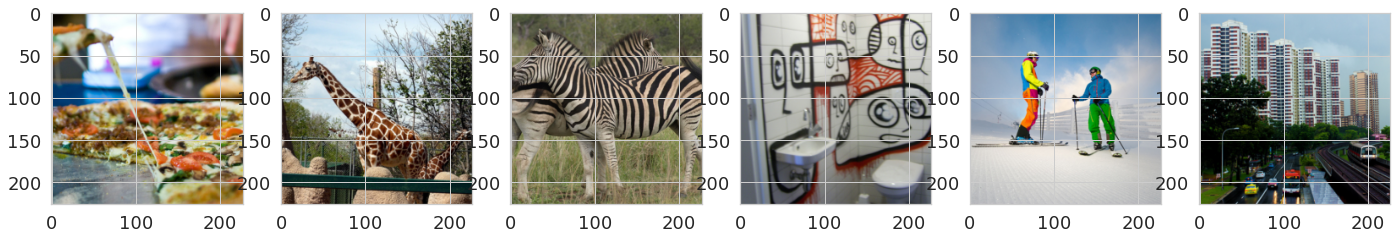

In [34]:
n_examples=6
plt.figure(figsize=(4*n_examples, 4))
for k, n in enumerate(np.random.randint(0,len(s_image_data), n_examples)):
    plt.subplot(1,n_examples,k+1)
    plt.imshow(s_image_data[n].transpose((1,2,0)))

In [35]:
print (s_image_data[n,0,0])
print (np.mean(s_image_data.astype(np.float64), axis=(0,2,3)))

[143 141 144 144 144 143 144 144 145 144 144 145 145 147 146 145 145 145
 146 145 146 144 144 145 146 146 146 146 145 147 148 148 149 150 149 151
 151 150 149 150 151 152 152 154 152 153 153 153 153 155 156 157 155 156
 157 156 153 154 155 156 157 157 157 158 158 157 158 158 158 158 159 159
 158 159 159 160 159 160 160 160 161 161 162 162 161 162 163 165 165 165
 165 166 167 168 169 169 167 167 167 167 168 169 168 167 167 168 167 166
 166 166 166 166 166 166 165 165 164 165 166 164 164 164 164 166 167 165
 164 165 165 165 166 165 166 165 166 168 168 166 167 169 168 167 169 169
 167 167 168 168 169 171 170 170 170 171 170 169 169 170 170 171 170 171
 171 171 171 171 171 170 170 171 171 171 172 172 173 171 172 172 172 172
 172 172 172 174 173 173 173 174 174 175 175 174 174 176 177 177 177 177
 177 178 178 178 179 180 180 179 179 179 178 177 177 177 177 178 177 177
 177 177 178 178 178 177 178 178 177 177 178]
[121.43106972 115.72682529 105.50476248]


In [36]:
from src.load_nsd import load_betas

subjects = [1]
voxel_data = {}
for k,s in enumerate(subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/nsdsyntheticbetas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=None, up_to=-1)
    print ('----------------------------')
    print (voxel_data[s].shape)

--------  subject 1  -------


FileNotFoundError: [Errno 2] No such file or directory: '/md_disk7/guoyuan/Mufan/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/nsdsyntheticbetas_fithrf_GLMdenoise_RR/'

# COCO indices
## Create a block of COCO IDs concordant with the 'subjectim' array 

In [37]:
import pandas as pd
nsd_stiminfo_file = '~/repo.data/datasets/nsd/dev/nsd_stim_info_merged.pkl'
stiminfo = pd.read_pickle(nsd_stiminfo_file)

FileNotFoundError: [Errno 2] No such file or directory: '/home/guoyuan/repo.data/datasets/nsd/dev/nsd_stim_info_merged.pkl'

In [38]:
subject_idx  = exp_design['subjectim']
print (subject_idx.shape)

cocoId_arr = np.zeros(shape=subject_idx.shape, dtype=int)
crop_arr   = np.zeros(shape=subject_idx.shape+(4,), dtype=np.float32)
for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    imageId = subject_idx[j]-1
    for i,k in enumerate(imageId):
        cocoId_arr[j,i] = (cocoId[nsdId==k])[0]
        crop_arr[j,i]   = stiminfo['cropBox'][k]

(8, 10000)


NameError: name 'stiminfo' is not defined

## Reload 

In [39]:
subject = 1

In [40]:
coco_info_set = h5py.File(stim_root + 'nsd_to_coco_indice_map.h5py', 'r')
cocoId_arr = np.copy(coco_info_set['cocoId'])
nsdcrop_arr = np.copy(coco_info_set['crop'])
coco_info_set.close()

print (cocoId_arr.shape)
print (nsdcrop_arr.shape)

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/md_disk7/guoyuan/Mufan/nsd/nsddata_stimuli/stimuli/nsd/nsd_to_coco_indice_map.h5py', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

TypeError: Invalid shape (425, 3, 425) for image data

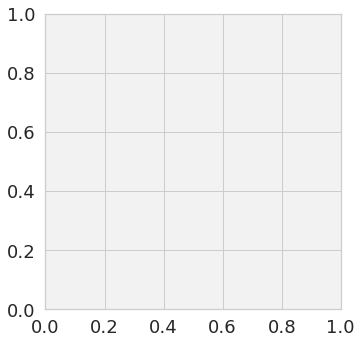

In [41]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

In [ ]:
import json
from collections import defaultdict

annDir = '/home/styvesg/repo.data/datasets/coco/'
imgDir = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic/' # combined folder with train2017 and val2017 png masks
panop_trn_annFile = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic_train2017.json'
panop_val_annFile = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic_val2017.json'

dataset = dict()
dataset = json.load(open(panop_trn_annFile, 'r'))

imgIdToAnns = defaultdict(list)
catIdToCat = defaultdict(list)
if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)
    for cat in dataset['categories']:
        catIdToCat[cat['id']].append(cat)
        
dataset = dict()
dataset = json.load(open(panop_val_annFile, 'r'))

if 'annotations' in dataset:
    for ann in dataset['annotations']:
        imgIdToAnns[ann['image_id']].append(ann)

In [ ]:
import skimage.io
from skimage.transform import resize

minSize = 227
start_idx = 3
n_idx = 1

plt.figure(figsize=(18,12))
for i in range(n_idx):
    nId = start_idx+i
    cId = cocoId_arr[subject-1, nId]
    print (cId)
    png_name = imgDir + '%012d.png' % cId
    print (png_name)
    crop = nsdcrop_arr[subject-1, nId]
    img = skimage.io.imread(png_name)

    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')

    plt.subplot(2,n_idx,i+1)
    plt.imshow(image_data[start_idx+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.imshow(croppedImg, alpha=.2)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.subplot(2,n_idx,n_idx+i+1)
    plt.imshow(croppedImg) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    ###
    imgSegIds = maskToUniqueIndices(croppedImg) # unique segment IDs
    catIds = getCategoryIDs(imgIdToAnns[cId], imgSegIds)
    print (catIds)
    print (getCategoryNames(catIdToCat, catIds))
    print (getSupercategoryNames(catIdToCat, catIds))

In [ ]:
stuff_annFile = annDir + 'stuff_annotations_trainval2017/annotations/stuff_train2017.json'
thing_annFile = annDir + 'annotations_trainval2017/annotations/instances_train2017.json'

from pycocotools.coco import COCO
coco_stuff = COCO(stuff_annFile)
coco_thing = COCO(thing_annFile)

In [42]:
# display COCO categories and supercategories
cats = coco_stuff.loadCats(coco_stuff.getCatIds())
stuff_nms=[cat['name'] for cat in cats]
print('COCO stuff categories: \n{}\n'.format(' '.join(stuff_nms)))
super_stuff_nms = list(set([cat['supercategory'] for cat in cats]))
print('COCO stuff supercategories: \n{}'.format(' '.join(set(super_stuff_nms))))

print ()
cats = coco_thing.loadCats(coco_thing.getCatIds())
thing_nms=[cat['name'] for cat in cats]
print('COCO thing categories: \n{}\n'.format(' '.join(thing_nms)))
super_thing_nms = list(set([cat['supercategory'] for cat in cats]))
print('COCO thing supercategories: \n{}'.format(' '.join(set(super_thing_nms))))

print ()
super_nms = super_thing_nms + super_stuff_nms
print('COCO supercategories: \n{}'.format(' '.join(set(super_nms))))

NameError: name 'coco_stuff' is not defined

In [43]:
print 'super category count = ', len(super_nms)
class_embbeding, label_map = {}, {}
for k,name in enumerate(super_nms):
    class_embbeding[name] = k
    label_map[k] = name 
    print name, ': ', coco_thing.getCatIds(supNms=[name]) + coco_stuff.getCatIds(supNms=[name])

SyntaxError: invalid syntax (141318689.py, line 1)

In [44]:
print (cocoMap[3938])

NameError: name 'cocoMap' is not defined

In [ ]:
import skimage.io
from skimage.transform import resize
minSize = 227
start_idx = 3938
n_idx = 5

plt.figure(figsize=(28,12))
for i in range(n_idx):
    cId = cocoId_arr[subject-1,start_idx+i]
    png_name = imgDir + '%012d.png' % cId
    crop = nsdcrop_arr[subject-1,start_idx+i]
    img = skimage.io.imread(png_name)
    
    croppedImg = applyCropToImg(img,crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')
    
    catIds = getCategoryIDs(imgIdToAnns[cId], maskToUniqueIndices(croppedImg))   
    plt.subplot(3,n_idx,i+1)  
    plt.title(getSupercategoryNames(catIdToCat, catIds), fontsize=10)    
    plt.ylabel('image')
    plt.imshow(image_data[start_idx+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(3,n_idx,n_idx+i+1)
    plt.imshow(croppedImg)
    plt.ylabel('local cat. index')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(3,n_idx,2*n_idx+i+1)
    croppedSuper = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    plt.ylabel('global super cat.')
    plt.imshow(croppedSuper.astype(np.float32) / len(super_nms)) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])

In [45]:
cocoMap = np.ones(shape=(73000), dtype=int) * -1
for j in range(len(subject_idx)):
    cocoId = np.array(stiminfo['cocoId'])[stiminfo['subject%d'%(j+1)].astype(bool)]
    nsdId = np.array(stiminfo['nsdId'])[stiminfo['subject%d'%(j+1)].astype(bool)] 
    cocoMap[nsdId] = cocoId
print (np.sum(cocoMap==-1))
print (cocoMap.shape)
print (stiminfo['cropBox'].shape)

NameError: name 'stiminfo' is not defined

In [ ]:
def getCategoryIDs(annotations, imgSegIds):
    segToCatId = defaultdict(list)
    for ann in annotations:
        for seg in ann['segments_info']:
            segToCatId[seg['id']] = seg['category_id']
    return [segToCatId[s] for s in imgSegIds if s in segToCatId]

In [46]:
start_idx = 3940
n_idx = 5

plt.figure(figsize=(28,8))
for i,cId in enumerate(cocoMap[start_idx:start_idx+n_idx]):
   
    nId = start_idx + i
    png_name = imgDir + '%012d.png' % cId
    crop = stiminfo['cropBox'][nId]

    img = skimage.io.imread(png_name)
    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')
    catIds = getCategoryIDs(imgIdToAnns[cId], maskToUniqueIndices(croppedImg))
    ###
    plt.subplot(2,n_idx,i+1)
    plt.title(getSupercategoryNames(catIdToCat, catIds), fontsize=10)  
    plt.imshow(croppedImg)
    plt.ylabel('local cat. index')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])
    ###
    plt.subplot(2,n_idx,n_idx+i+1)
    croppedSuper = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
    plt.ylabel('global super cat.')
    plt.imshow(croppedSuper.astype(np.float32) / len(super_nms)) 
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_ticks([])

NameError: name 'imgDir' is not defined

<Figure size 2016x576 with 0 Axes>

In [47]:
import skimage.io
from skimage.transform import resize
minSize = 227

annDir = '/home/styvesg/repo.data/datasets/coco/'
imgDir = annDir + 'panoptic_annotations_trainval2017/annotations/panoptic/' # combined folder with train2017 and val2017 png masks

cocoCat = {}
for nId,cId in tqdm(enumerate(cocoMap)):
    png_name = imgDir + '%012d.png' % cId
    crop = stiminfo['cropBox'][nId]
    ##
    img = skimage.io.imread(png_name)
    croppedImg = applyCropToImg(img, crop)
    croppedImg = (resize(croppedImg, (minSize,minSize), order=0) * 256.).astype('uint8')    
    imgSegIds = maskToUniqueIndices(croppedImg) # unique segment IDs
    catIds = getCategoryIDs(imgIdToAnns[cId], imgSegIds)
    ##
    cocoCat[nId] = {}
    cocoCat[nId]['catId'] = catIds
    cocoCat[nId]['catName'] = getCategoryNames(catIdToCat, catIds)
    cocoCat[nId]['supName'] = getSupercategoryNames(catIdToCat, catIds) 

0it [00:00, ?it/s]


NameError: name 'stiminfo' is not defined

In [ ]:
print class_embbeding.keys()

In [ ]:
print cocoCat[0]

In [ ]:
emb_dims = np.max(label_map.keys())+1
supEmb = np.zeros(shape=(len(cocoMap), emb_dims), dtype=int)
for k,vv in cocoCat.items():
    for v in vv['supName']:
        i = class_embbeding[v]
        supEmb[k][i] = 1

In [ ]:
plt.figure(figsize=(30,4))
plt.imshow(supEmb[:500].T)

In [ ]:
from src.file_utility import save_stuff, flatten_dict, embed_dict

label_dict = {
    'embedding': supEmb, 
    'label_map': label_map,
    'cocoId': cocoId_arr, 
    'crop': crop_arr, 
    'cocoMap': cocoMap
    }

save_stuff(stim_root + "embedding_73K", flatten_dict(label_dict))

# Label maps for all subjects
This takes a long time since we need to load the image and annotations one-by-one and reinterpret them. 

In [ ]:
nx = 227
nc = len(super_nms)

for k in range(len(cocoId_arr)): # for all subjects
    l_image_data = np.zeros(shape=(len(cocoId_arr[k]), nx, nx), dtype=np.uint8)

    for i, (cId, crop) in tqdm(enumerate(zip(cocoId_arr[k], nsdcrop_arr[k]))):
        png_name = imgDir + '%012d.png' % cId
        img = skimage.io.imread(png_name)

        croppedImg = applyCropToImg(img, crop)
        croppedImg = (resize(croppedImg, (nx, nx), order=0) * 255.).astype('uint8')
        l_image_data[i,...] = supercategoryMap(croppedImg, imgIdToAnns[cId], class_embbeding)
        
    print l_image_data.shape
    save_stuff("%sS%d_supercategory_%d"%(stim_root, k+1, nx), flatten_dict({'labels': l_image_data, 'label_map': label_map, 'label_count': nc}))